In [1]:
import os
import sys

path = os.getcwd()
par_path = os.path.abspath(os.pardir)
sys.path.append(par_path)

from utils.data import ExtractROI, AtlasDataset

import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import torch

import csv
import math
import random as rand
from tqdm import tqdm

from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

from models.unet import UNet
from models.moment_unet import *

from monai.metrics import HausdorffDistanceMetric
from monai.metrics import DiceMetric, MeanIoU
from monai.transforms import AsDiscrete, EnsureType

from sklearn.decomposition import IncrementalPCA, PCA
from scipy.stats import norm

In [2]:
# seed for reproducibility
torch.manual_seed(0)

**NOTE**: To load this dataset, you must have already run the data_generator.ipynb notebook. Make sure to paste in the correct ROI directories under train_dir, test_dir, and label_map file

In [3]:
# Please paste in the path to the directory where the data is stored for train and test by first running data_generator.py
train_dir = '/nafs/dtward/allen/rois/64x64_sample_rate_0_8_all/train/'
test_dir = '/nafs/dtward/allen/rois/64x64_sample_rate_0_8_all/test/'

# The label map file can be one of divisions.csv, organs.csv, structures.csv, substructures.csv, categories.csv for the Allen Institute data
label_map_file = '/nafs/dtward/allen/rois/divisions.csv' 

train_dataset = AtlasDataset(data_dir=train_dir, label_map_file=label_map_file)
test_dataset = AtlasDataset(data_dir=test_dir, label_map_file=label_map_file)

bs = 16
train_loader = DataLoader(train_dataset, batch_size=bs, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=bs, shuffle=True)

In [4]:
# Load the model weights for the segmentation model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet(img_channels=501, num_classes=train_dataset.num_classes, n0=16).to(device)
model.load_state_dict(torch.load('segmentation/results/run1004/segmentation/unet/unet1004.pt'))
model.eval()

UNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(501, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (conv_maxpool): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(32, eps=1e-05, momentum=

## **PCA on Inputs**

In [5]:
# We will take some batch of inputs and apply PCA on it
imgs_tensor, lbls = next(iter(train_loader))

C = imgs_tensor.shape[1]
M = imgs_tensor.shape[2] * imgs_tensor.shape[3]

imgs_ = imgs_tensor.numpy()
imgs_ = imgs_.transpose(1, 0, 2, 3).reshape(imgs_tensor.shape[1], -1)
imgs_.shape

(501, 65536)

In [6]:
mean = np.mean(imgs_, -1, keepdims=True)
imgs0_ = imgs_ - mean

In [7]:
Sigma = (imgs0_@imgs0_.T) / imgs0_.shape[0]
Sigma.shape

(501, 501)

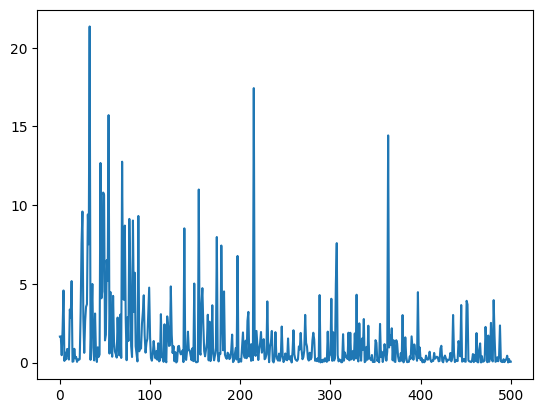

In [8]:
# Lets take a look at the covariance
fig, ax = plt.subplots()
ax.plot(np.diag(Sigma))

In [9]:
w, v = np.linalg.eigh(Sigma)
w = w[::-1]
v = v[:,::-1]

In [10]:
transformed_imgs_ = (v[:, :3].T@imgs0_) / np.sqrt(w[:3, None])

In [11]:
transformed_imgs = transformed_imgs_.reshape(3, imgs_tensor.shape[0], imgs_tensor.shape[2], imgs_tensor.shape[3]).transpose(1, 0, 2, 3)

In [12]:
print(transformed_imgs[0].shape)

(3, 64, 64)


Text(0.5, 1.0, 'PC1 using cell density only')

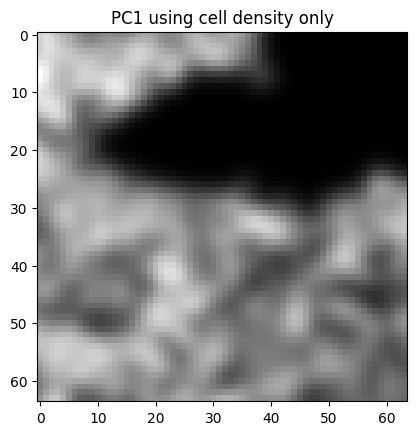

In [13]:
# Lets take a look at the first principal component
fig, ax = plt.subplots()
ax.imshow(transformed_imgs[0, 0], cmap='gray')

In [14]:
transformed_data_01 = 1.0 / (1.0 + np.exp(-transformed_imgs))

In [15]:
transformed_imgs_01 = norm.cdf(transformed_imgs)

Text(0.5, 1.0, 'Three principal components with logistic scaling, use cell density only for 1D signal')

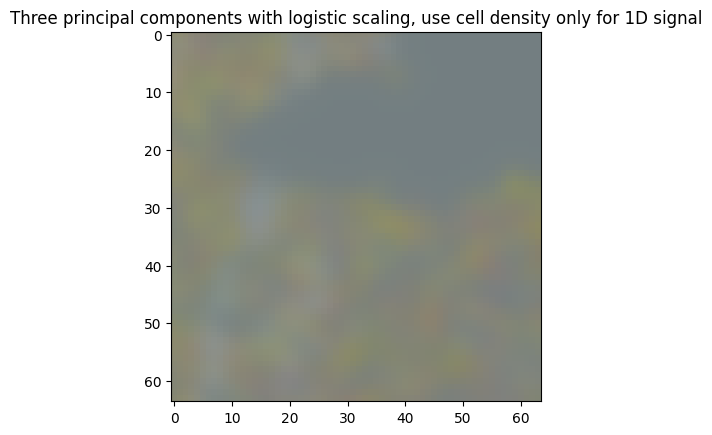

In [16]:
# Lets take a look at the three principal components with logistic scaling
fig, ax = plt.subplots()
ax.imshow(transformed_imgs_01[0, :3].transpose(1, 2, 0), cmap='gray')
ax.set_title('Three principal components with logistic scaling, use cell density only for 1D signal')

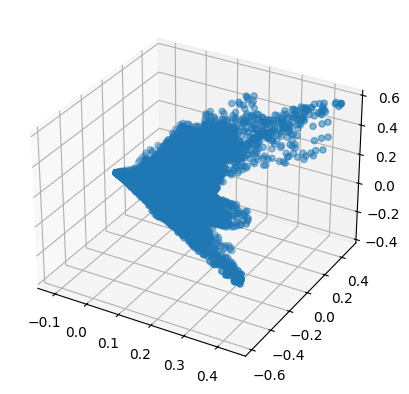

In [17]:
# A 3D scatter plot of the three principal components
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(*transformed_imgs_)

## **PCA on Outputs**

In [18]:
# The same exact process as above but applied to the output of the segmentation model
preds = model(imgs_tensor.to(device))
preds = preds.detach().cpu()

C = preds.shape[1]
M = preds.shape[2] * preds.shape[3]

preds_ = preds.numpy()
preds_ = preds_.transpose(1, 0, 2, 3).reshape(preds.shape[1], -1)
preds_.shape

(26, 65536)

In [19]:
mean = np.mean(preds_, -1, keepdims=True)
preds0_ = preds_ - mean

In [20]:
Sigma = (preds0_@preds0_.T) / preds0_.shape[0]
Sigma.shape

(26, 26)

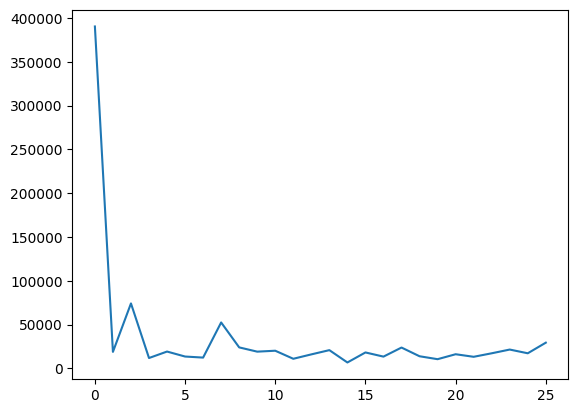

In [21]:
# Lets take a look at the covariance
fig, ax = plt.subplots()
ax.plot(np.diag(Sigma))

In [22]:
w, v = np.linalg.eigh(Sigma)
w = w[::-1]
v = v[:,::-1]

In [23]:
transformed_preds_ = (v[:, :3].T@preds0_) / np.sqrt(w[:3, None])

In [24]:
transformed_preds = transformed_preds_.reshape(3, preds.shape[0], preds.shape[2], preds.shape[3]).transpose(1, 0, 2, 3)

In [25]:
print(transformed_preds[0].shape)

(3, 64, 64)


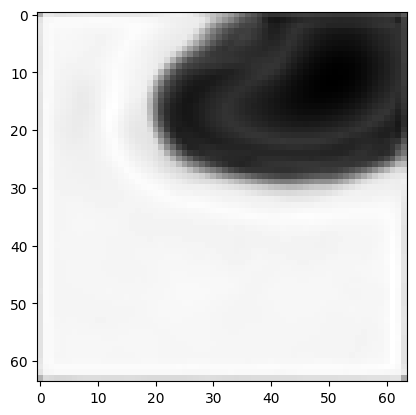

In [26]:
# Lets take a look at the first principal component
fig, ax = plt.subplots()
ax.imshow(transformed_preds[0, 0], cmap='gray')

In [27]:
transformed_preds_01 = 1.0 / (1.0 + np.exp(-transformed_preds))

In [28]:
transformed_preds_01 = norm.cdf(transformed_preds)

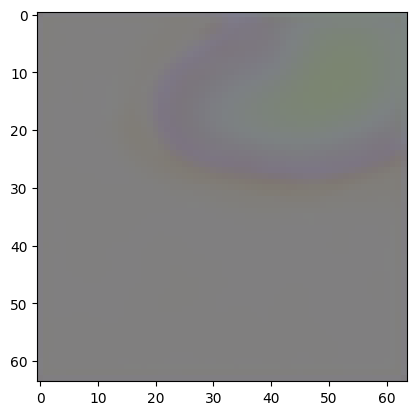

In [29]:
# Lets take a look at the three principal components with logistic scaling
fig, ax = plt.subplots()
ax.imshow(transformed_preds_01[0, :3].transpose(1, 2, 0), cmap='gray')

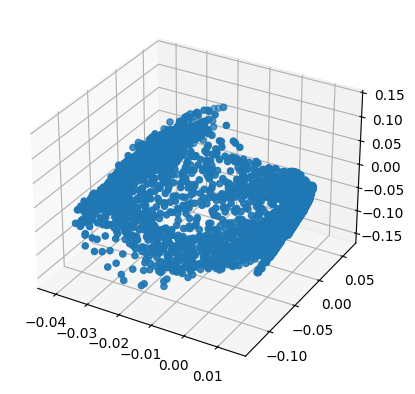

In [30]:
# A 3D scatter plot of the three principal components
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(*transformed_preds_)